# Aspect-based Sentiment Regression and Evaluation for Beer Reviews
### (Fine-tuned from a Pretrained BERT Model: GiRak/beer-sentiment-bert)

## 1. Import Libraries

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoConfig
import pandas as pd
import numpy as np

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("Warning: GPU not available, using CPU.")

Using device: cuda
GPU name: NVIDIA L4


## 2. ABSARegressor: BERT-based Aspect Sentiment Regression Model
- Defines a PyTorch neural network for aspect-based sentiment regression.
- Uses a pre-trained BERT model as the encoder to extract text features.
- Adds a linear regression head to predict a continuous sentiment score for each aspect.
- Optionally allows freezing the BERT encoder during training for efficiency or transfer learning.
- Uses mean squared error (MSE) loss for regression tasks.

In [ ]:
class ABSARegressor(nn.Module):
    def __init__(self, base_model_name="GiRak/beer-sentiment-bert", dropout_rate=0.1, freeze_encoder=True):
        super().__init__()
        config = AutoConfig.from_pretrained(base_model_name)
        self.bert = AutoModel.from_pretrained(base_model_name, config=config)
        if freeze_encoder:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout = nn.Dropout(dropout_rate)
        hidden_size = config.hidden_size
        self.regressor = nn.Linear(hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Use **kwargs to accept all possible input parameters
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled = bert_outputs.pooler_output
        x = self.dropout(pooled)
        logits = self.regressor(x).squeeze(-1)
        output = {"logits": logits}
        if labels is not None:
            loss_fct = nn.MSELoss()
            output["loss"] = loss_fct(logits, labels)
        return output

## 3. BeerReviewAnalyzer: Aspect-based Sentiment Analysis Pipeline
### This class loads the fine-tuned BERT regression model and provides methods to:
- Preprocess and tokenize review text for each aspect (look, smell, taste, feel)
- Predict aspect-specific sentiment scores for a given review
- Aggregate predictions for all aspects in a review

In [ ]:
import torch

class BeerReviewAnalyzer:
    def __init__(self, model_path="/content/drive/MyDrive/models/absa_bert_regressor_02"):
        # Detect device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        if self.device.type == "cuda":
            print(f"GPU name: {torch.cuda.get_device_name(0)}")
        else:
            print("Warning: GPU not available, using CPU.")

        # Load model and tokenizer
        self.model = ABSARegressor()
        from safetensors.torch import load_file
        self.model.load_state_dict(load_file(f"{model_path}/model.safetensors"))
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model.eval()
        self.model.to(self.device)  # Move model to device

        self.aspects = ["look", "smell", "taste", "feel"]

    def preprocess_text(self, text, aspect):
        input_text = f"{aspect}: {text}"
        inputs = self.tokenizer(
            input_text,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )
        return inputs

    def predict_score(self, text, aspect):
        inputs = self.preprocess_text(text, aspect)
        # Move all tensors to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            model_inputs = {
                'input_ids': inputs['input_ids'],
                'attention_mask': inputs['attention_mask']
            }
            if 'token_type_ids' in inputs:
                model_inputs['token_type_ids'] = inputs['token_type_ids']
            outputs = self.model(**model_inputs)
            score = outputs["logits"].item()
        return score

    def analyze_review(self, text):
        results = {}
        for aspect in self.aspects:
            score = self.predict_score(text, aspect)
            results[aspect] = round(score, 2)
        return results

## 4. Single Review Aspect-based Sentiment Analysis
- Instantiates the BeerReviewAnalyzer for aspect-based sentiment regression.
- Analyzes a single beer review, predicting sentiment scores for each aspect (look, smell, taste, feel).
- Prints the predicted scores for each aspect on a 5-point scale.

In [ ]:
# Single Review Analysis
analyzer = BeerReviewAnalyzer()

review = """
This beer has a beautiful golden color with a thick white head.
The aroma is full of citrus and pine notes.
The taste is balanced with a nice hop bitterness and malt sweetness.
The mouthfeel is smooth and creamy.
"""

scores = analyzer.analyze_review(review)
print("Review Analysis Results:")
for aspect, score in scores.items():
    print(f"{aspect.capitalize()}: {score}/5.0")

Using device: cuda
GPU name: NVIDIA L4
Review Analysis Results:
Look: 3.12/5.0
Smell: 3.0/5.0
Taste: 2.98/5.0
Feel: 3.02/5.0


## 5. Batch Aspect-based Sentiment Regression and Evaluation
- Batch prediction of sentiment scores for each aspect (look, smell, taste, feel) in beer reviews
- Calculate overall and aspect-wise regression metrics (MAE, RMSE, R²)
- Visualize and save the prediction results


Check the number of missing values in each column:
beer_id                0
username               8
date                   0
text                   0
look                 588
smell                588
taste                588
feel                 588
overall              588
score                  0
sentiment              0
has_look               0
has_smell              0
has_taste              0
has_feel               0
mentioned_aspects      0
score_bin            136
dtype: int64

Number of missing values in the first 1000 rows:
beer_id                0
username               8
date                   0
text                   0
look                 588
smell                588
taste                588
feel                 588
overall              588
score                  0
sentiment              0
has_look               0
has_smell              0
has_taste              0
has_feel               0
mentioned_aspects      0
score_bin            136
dtype: int64

Number of rows after c

Analyzing reviews:   0%|          | 0/19412 [00:00<?, ?it/s]<ipython-input-16-8be9849b4e0f>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({
Analyzing reviews: 100%|██████████| 19412/19412 [17:16<00:00, 18.73it/s]



Overall Evaluation Metrics:
Mean Absolute Error (MAE): 0.580
Root Mean Squared Error (RMSE): 0.746
R-squared Score: 0.426

Evaluation Metrics by Aspect:

Look:
MAE: 0.548
RMSE: 0.703
R-squared: 0.268

Smell:
MAE: 0.561
RMSE: 0.717
R-squared: 0.480

Taste:
MAE: 0.631
RMSE: 0.808
R-squared: 0.458

Feel:
MAE: 0.581
RMSE: 0.750
R-squared: 0.405


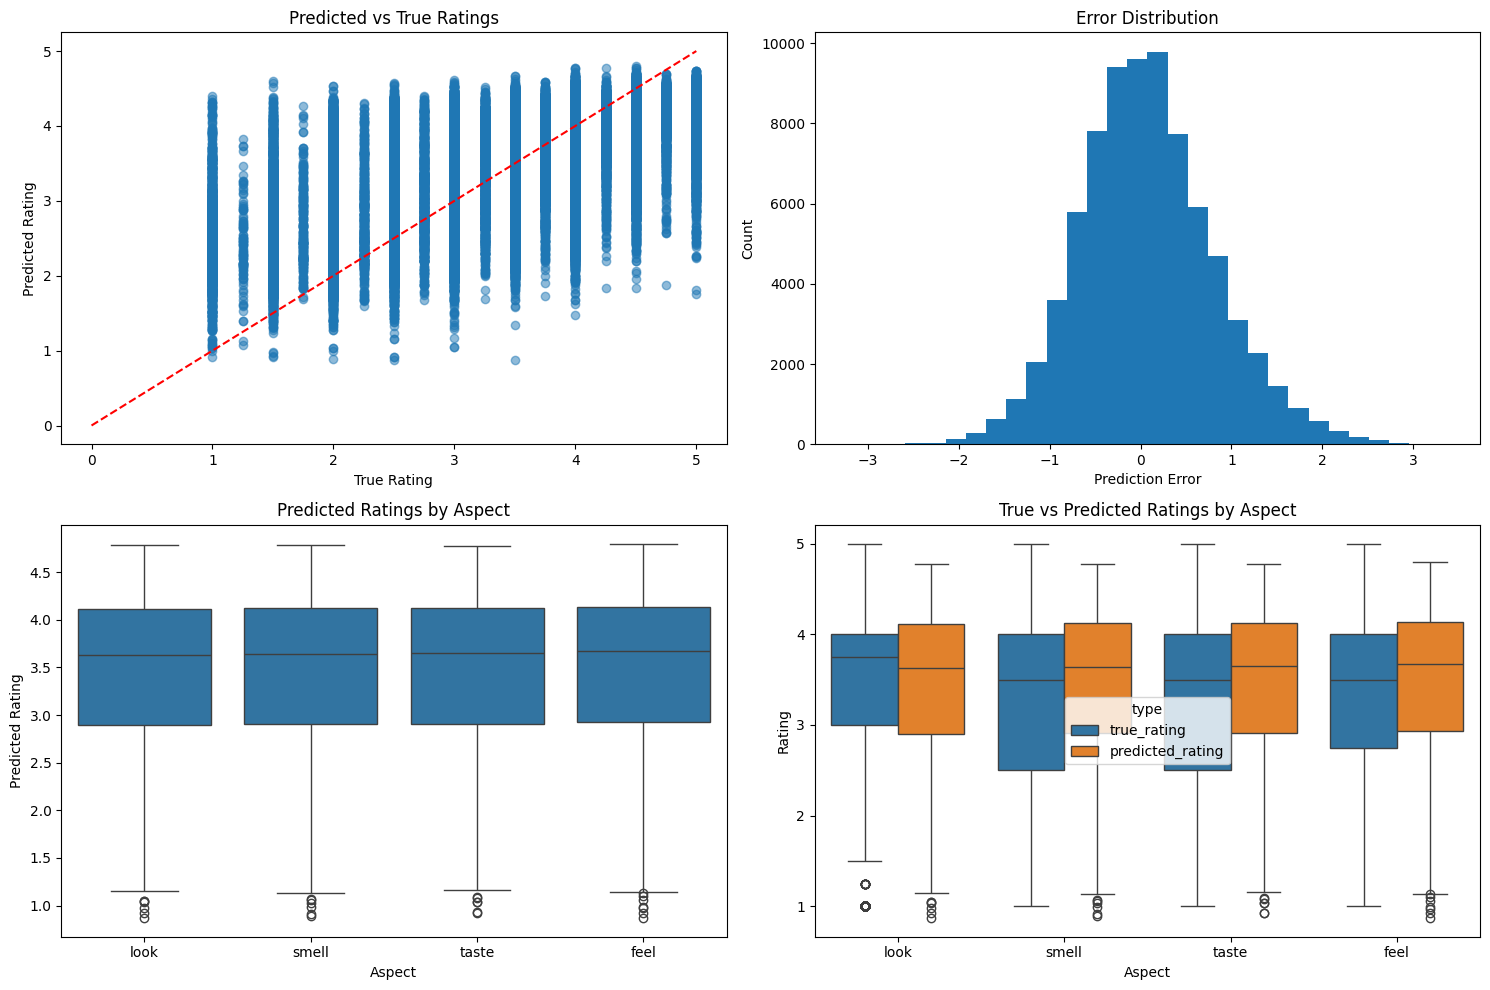


Results have been saved to 'model_evaluation_results.csv'

Sample Predictions:

Beer ID: 55099
Aspect: look
True Rating: 4.50
Predicted Rating: 2.41
Review: poured on-tap local english pub. - nice amber color maybe slightly hazy orangish copper tint. small ...

Beer ID: 55099
Aspect: look
True Rating: 4.50
Predicted Rating: 2.41
Review: okay, may re-review due fact great dipa prior. poured pint glass bottle pictured. a: nice copper-gol...

Beer ID: 55099
Aspect: smell
True Rating: 2.50
Predicted Rating: 2.43
Review: poured on-tap local english pub. - nice amber color maybe slightly hazy orangish copper tint. small ...

Beer ID: 55099
Aspect: smell
True Rating: 2.50
Predicted Rating: 2.43
Review: okay, may re-review due fact great dipa prior. poured pint glass bottle pictured. a: nice copper-gol...

Beer ID: 55099
Aspect: taste
True Rating: 3.00
Predicted Rating: 2.43
Review: poured on-tap local english pub. - nice amber color maybe slightly hazy orangish copper tint. small ...


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


df = pd.read_csv("/content/drive/MyDrive/Web Mining Project/data/test_preprocessed_binned.csv")

print("Check the number of missing values in each column:")
print(df.isnull().sum())

df_test = df

print("\nNumber of missing values in the first 1000 rows:")
print(df_test.isnull().sum())

# Delete rows containing missing values
df_test = df_test.dropna(subset=['text', 'look', 'smell', 'taste', 'feel'])

print(f"\nNumber of rows after cleaning: {len(df_test)}")

# Create result storage DataFrame
results = pd.DataFrame(columns=['beer_id', 'aspect', 'true_rating', 'predicted_rating'])

# Analyze each review
analyzer = BeerReviewAnalyzer()

for idx, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Analyzing reviews"):
    review = row['text']
    true_ratings = {
        'look': float(row['look']),
        'smell': float(row['smell']),
        'taste': float(row['taste']),
        'feel': float(row['feel'])
    }
    # Get model prediction
    predicted_ratings = analyzer.analyze_review(review)
    # Store results
    for aspect in ['look', 'smell', 'taste', 'feel']:
        results = pd.concat([results, pd.DataFrame({
            'beer_id': [row['beer_id']],
            'aspect': [aspect],
            'true_rating': [true_ratings[aspect]],
            'predicted_rating': [predicted_ratings[aspect]]
        })], ignore_index=True)


# Calculate overall evaluation metrics
mae = mean_absolute_error(results['true_rating'], results['predicted_rating'])
rmse = np.sqrt(mean_squared_error(results['true_rating'], results['predicted_rating']))
r2 = r2_score(results['true_rating'], results['predicted_rating'])

print("\nOverall Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R-squared Score: {r2:.3f}")

# Calculate evaluation metrics by aspect
print("\nEvaluation Metrics by Aspect:")
for aspect in ['look', 'smell', 'taste', 'feel']:
    aspect_results = results[results['aspect'] == aspect]
    aspect_mae = mean_absolute_error(aspect_results['true_rating'], aspect_results['predicted_rating'])
    aspect_rmse = np.sqrt(mean_squared_error(aspect_results['true_rating'], aspect_results['predicted_rating']))
    aspect_r2 = r2_score(aspect_results['true_rating'], aspect_results['predicted_rating'])

    print(f"\n{aspect.capitalize()}:")
    print(f"MAE: {aspect_mae:.3f}")
    print(f"RMSE: {aspect_rmse:.3f}")
    print(f"R-squared: {aspect_r2:.3f}")


# Visualize prediction results
plt.figure(figsize=(15, 10))

# Scatter plot of predicted vs true values
plt.subplot(2, 2, 1)
plt.scatter(results['true_rating'], results['predicted_rating'], alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')
plt.title('Predicted vs True Ratings')

# Histogram of prediction errors
plt.subplot(2, 2, 2)
errors = results['predicted_rating'] - results['true_rating']
plt.hist(errors, bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Error Distribution')

# Box plot by aspect
plt.subplot(2, 2, 3)
sns.boxplot(x='aspect', y='predicted_rating', data=results)
plt.xlabel('Aspect')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings by Aspect')

# Scatter plot of true vs predicted values
plt.subplot(2, 2, 4)
results_melted = pd.melt(results, id_vars=['beer_id', 'aspect'],
                        value_vars=['true_rating', 'predicted_rating'],
                        var_name='type', value_name='rating')
sns.boxplot(x='aspect', y='rating', hue='type', data=results_melted)
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.title('True vs Predicted Ratings by Aspect')

plt.tight_layout()
plt.show()

# Save results to CSV file, including more information
results_with_info = pd.merge(
    results,
    df_test[['beer_id', 'username', 'date', 'text', 'overall', 'score']],
    on='beer_id',
    how='left'
)
results_with_info.to_csv('/content/drive/MyDrive/Web Mining Project/data/dataset_with_sentiment_score/prediction_sentiment_score.csv', index=False)
print("\nResults have been saved to 'model_evaluation_results.csv'")

# Print some sample results
print("\nSample Predictions:")
sample_results = results_with_info.head(5)
for _, row in sample_results.iterrows():
    print(f"\nBeer ID: {row['beer_id']}")
    print(f"Aspect: {row['aspect']}")
    print(f"True Rating: {row['true_rating']:.2f}")
    print(f"Predicted Rating: {row['predicted_rating']:.2f}")
    print(f"Review: {row['text'][:100]}...") # Only show the first 100 characters

In [ ]:
import pandas as pd


df_pred = results_with_info.pivot_table(
    index=['username', 'beer_id', 'date', 'text', 'overall', 'score'],
    columns='aspect',
    values='predicted_rating'
)
df_pred.columns = [f"{aspect}_predicted_rating" for aspect in df_pred.columns]

df_true = results_with_info.pivot_table(
    index=['username', 'beer_id', 'date', 'text', 'overall', 'score'],
    columns='aspect',
    values='true_rating'
)
df_true.columns = [f"{aspect}_true_rating" for aspect in df_true.columns]

df_wide = pd.concat([df_pred, df_true], axis=1).reset_index()

cols = ['username', 'beer_id', 'feel_predicted_rating', 'look_predicted_rating', 'smell_predicted_rating', 'taste_predicted_rating',
        'feel_true_rating', 'look_true_rating', 'smell_true_rating', 'taste_true_rating',
        'date', 'text', 'overall', 'score']
cols = [col for col in cols if col in df_wide.columns]
df_wide = df_wide[cols]

print(df_wide.head())

        username  beer_id  feel_predicted_rating  look_predicted_rating  \
0        00trayn     1180               3.544667               3.512667   
1        00trayn   105250               3.850000               3.850000   
2       05Harley     2269               3.996667               3.968333   
3       05Harley    60118               3.980000               3.945000   
4  1000lbgrizzly    67439               4.390000               4.380000   

   smell_predicted_rating  taste_predicted_rating  feel_true_rating  \
0                3.522667                3.523333          3.133333   
1                3.870000                3.850000          5.000000   
2                3.973333                3.980000          3.916667   
3                3.955000                3.955000          3.875000   
4                4.380000                4.380000          4.000000   

   look_true_rating  smell_true_rating  taste_true_rating        date  \
0          3.266667           3.433333           

In [ ]:
df_wide.to_csv('/content/drive/MyDrive/Web Mining Project/data/dataset_with_sentiment_score/RecSys_AspectSentiment.csv', index=False)
print("Wide-format results saved to 'results_wide.csv'")

Wide-format results saved to 'results_wide.csv'


In [ ]:
df_wide

,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating,date,text,overall,score
0,00trayn,1180,3.544667,3.512667,3.522667,3.523333,3.133333,3.266667,3.433333,3.266667,2012-01-17,got tap dogfish head alehouse fairfax. - poure...,4.0,3.97
1,00trayn,105250,3.850000,3.850000,3.870000,3.850000,5.000000,5.000000,5.000000,5.000000,2013-12-17,"- beer pours deep, dark reddish-brown hint tra...",5.0,5.00
2,05Harley,2269,3.996667,3.968333,3.973333,3.980000,3.916667,4.125000,4.166667,4.250000,2012-01-22,bottle # ni110803mn 31683 best late 2014 purch...,4.0,3.92
3,05Harley,60118,3.980000,3.945000,3.955000,3.955000,3.875000,4.125000,3.625000,4.125000,2013-01-12,"purchased valley players theater waitsfield, v...",3.5,3.31
4,1000lbgrizzly,67439,4.390000,4.380000,4.380000,4.380000,4.000000,4.000000,4.750000,4.250000,2017-04-28,"dark copper hazy body tan 3d semi-solid head, ...",4.5,4.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19399,zoso1967,2392,3.755625,3.738125,3.745625,3.752500,3.593750,3.859375,3.640625,3.546875,2010-03-07,served dfh brewpub pitch black collar head aro...,2.0,2.31
19400,zoso1967,694,4.021429,4.010000,4.015714,4.021429,4.285714,3.714286,4.000000,4.285714,2010-03-17,"pours cloudy, slightly orange gold color plent...",3.5,4.10
19401,zoso1967,47695,3.713333,3.696667,3.688333,3.701667,3.583333,3.958333,3.750000,3.333333,2011-07-19,thanks tcgoalie sharing brew tasting. review w...,4.5,4.54
19402,zoso1967,18687,3.940000,3.900000,3.920000,3.935000,3.500000,3.250000,2.750000,2.750000,2010-09-18,pours crystal clear light golden bright white ...,4.0,3.36


## 6. Dataset splitting for recommender systems

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train and test sets (80% train, 20% test)
train_df, test_df = train_test_split(
    df_wide,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# Save the splits to CSV files
train_df.to_csv('/content/drive/MyDrive/Web Mining Project/data/dataset_with_sentiment_score/RecSys_AspectSentiment_train.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/Web Mining Project/data/dataset_with_sentiment_score/RecSys_AspectSentiment_test.csv', index=False)

print("Train and test sets have been saved")

Train and test sets have been saved
